In [2]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)
/home/joakim/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
path = "data/work_data/sample/"
#path = "data/work_data/"
#path = "data/base_data/"
model_path = "model/"
batch_size=10

In [4]:
import utils; reload(utils)
from utils import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function
from keras.layers import Input, Dense
from keras.models import Model
from keras.preprocessing import image
import os
from glob import glob
import numpy as np

In [9]:
from shutil import copyfile
def train_valid_split(from_dir, to_dir, percent_valid=20.0, sample=True):
    label_name = from_dir.split("/")[-1:][0]
    %mkdir -p $to_dir/"valid"/$label_name
    %mkdir -p $to_dir/"train"/$label_name
    g = glob('{}/*.jpg'.format(from_dir))
    shuf = np.random.permutation(g)
    size = int(shuf.size/20.0) if sample else shuf.size
    num_valid = int(size*(percent_valid/100.0))
    num_train = int(size - num_valid)
    for i in range(num_valid): 
        filename = "/".join(shuf[i].split("/")[-2:])
        copyfile(shuf[i], '{}/{}/{}'.format(to_dir, "valid", filename))
    for i in range(num_train): 
        filename = "/".join(shuf[i + num_valid].split("/")[-2:])
        copyfile(shuf[i + num_valid], '{}/{}/{}'.format(to_dir, "train", filename))

In [73]:
%cd data
%ls

/home/joakim/projects/KaggleFisheries
data/  fisheries.ipynb  utils.py*  vgg16bn.py*


In [10]:
def copy_train_valid(new_path, sample=True):    
    path = "base_data"
    label_dirs = os.listdir(path)
    print(label_dirs)
    for dir_name in label_dirs:
        train_valid_split('{}/{}'.format(path, dir_name), new_path, sample=sample)

In [68]:
#copy_train_valid("work_data", False)
#copy_train_valid("work_data/sample")

['OTHER', 'SHARK', 'DOL', 'ALB', 'LAG', 'NoF', 'BET', 'YFT']
['OTHER', 'SHARK', 'DOL', 'ALB', 'LAG', 'NoF', 'BET', 'YFT']


In [5]:
size=(500,500)
batches = get_batches(path+'train', batch_size=batch_size, target_size=size)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False, target_size=size)

Found 150 images belonging to 8 classes.
Found 34 images belonging to 8 classes.


Given our images, what sizes is it useful to target?

By doing the query below we can see that there are around 15 images out of 3000+ in our training-set that are below 1000 pixels width. This indicates we are throwing away important info by scaling down to 224x224 which is the default VGG-size.

In [9]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in batches.filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

import collections
collections.Counter(sizes)

Counter({(1192, 670): 8,
         (1276, 718): 9,
         (1280, 720): 90,
         (1280, 750): 21,
         (1280, 924): 2,
         (1280, 974): 16,
         (1334, 750): 2,
         (1732, 974): 2})

In [6]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN(size)
model = vgg.model

vgg16_bn_conv.h5


In [80]:
import annotationHandler; reload(annotationHandler)

<module 'annotationHandler' from 'annotationHandler.py'>

In [81]:
train_bboxes = annotationHandler.create_bbx("data/annotations", size, batches.filenames, path+"train")

Annotations for 3297 images found.
Creating blank bounding boxes for the rest.


In [94]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(bboxes, data, i):
    bb = bboxes[i]
    plot(data[i])
    plt.gca().add_patch(create_rect(bb))
data = get_data(path+"train", target_size=size)

Found 150 images belonging to 8 classes.


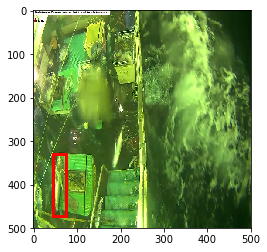

In [95]:
show_bb(train_bboxes, data, 0)

In [9]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

For the time being, we seem to be getting 0.85 val_accuracy with the full set and a 80/20 split.

Running with the whole set from now on, so val_acc will be useless.

In [10]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5)
                #validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/5
3777/3777 [==============================] - 97s - loss: 2.7884 - acc: 0.5295      

In [12]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5)

Epoch 1/5
3777/3777 [==============================] - 68s - loss: 1.8827 - acc: 0.7223      

In [8]:
model.compile(optimizer=Adam(1e-4),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5)

Epoch 1/5
3777/3777 [==============================] - 63s - loss: 1.7409 - acc: 0.7742      

In [16]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5)

Epoch 1/5
3777/3777 [==============================] - 63s - loss: 1.4893 - acc: 0.7871      

In [13]:
model.save_weights(path+'results/224Vgg16bn.h5')

In [9]:
model.load_weights(path+'results/224Vgg16bn.h5')

In [10]:
test_batches = get_batches(path+'test', batch_size=batch_size, shuffle=False, target_size=size, class_mode=None)

Found 1000 images belonging to 1 classes.


In [12]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [13]:
print(preds[:5])

[[  1.1593e-14   1.1043e-23   1.5629e-21   7.1915e-27   1.0000e+00   1.4255e-21   4.1544e-23
    3.8688e-20]
 [  1.0000e+00   2.8802e-20   0.0000e+00   0.0000e+00   2.8026e-45   3.3257e-23   2.8380e-39
    4.0144e-15]
 [  1.0000e+00   1.8874e-09   5.7772e-26   1.8036e-17   2.3838e-19   1.3268e-09   6.1770e-15
    1.2172e-12]
 [  1.0000e+00   1.2164e-13   3.6311e-23   7.9435e-20   7.8481e-20   2.0960e-12   2.8076e-20
    5.0634e-20]
 [  9.9948e-01   9.9395e-14   7.7330e-20   6.4311e-25   6.8873e-12   1.6250e-07   9.2290e-11
    5.1758e-04]]


Find which labels are which index.

In [16]:
val_batches = get_batches(path+'train', batch_size=batch_size, shuffle=False, target_size=size, class_mode=None)

Found 3777 images belonging to 8 classes.


In [17]:
probs = model.predict_generator(val_batches, 100)

In [52]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = test_batches.filenames
ids = np.array([f[8:] for f in filenames])

In [77]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [82]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [83]:
subm = do_clip(preds,0.82)

In [84]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', ids)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
1,img_00007.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
2,img_00009.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
4,img_00027.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714


In [85]:
submission.to_csv(path + 'results/fishy2.csv', index=False)